# CSE 5524 HW Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [235]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
import skimage
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color
from skimage import io, data 
from numpy.linalg import eig
from scipy import ndimage, misc
from scipy.ndimage import median_filter

### Read images and store in a list

In [276]:
#Following section reads the input images

path = glob.glob("input_images/*.bmp")                   #Define path for folder containing 22 input images
inputImagesList = []                                     #Create empty list to store input images

for i in range(22):
    if (i < 9):
        n = skimage.io.imread('input_images/' + 'aerobic-00' + str(i+1) + '.bmp')
        inputImagesList.append(n)
    else:
        n = skimage.io.imread('input_images/' + 'aerobic-0' + str(i+1) + '.bmp')
        inputImagesList.append(n)

### Create function to compute difference image with threshhold value 'T'

In [277]:
def differenceImages(T):
    
    randomList = []                                   #Create empty list to store difference images
    i = 0
    a,b = inputImagesList[0].shape

    for i in range(len(inputImagesList) - 1):
        image1 = inputImagesList[i]
        image2 = inputImagesList[i+1]
        image3 = np.zeros((a,b))
        for j in range(a):
            for k in range(b):
                if((abs(int(image1[j][k]) - int(image2[j][k]))) >= T):
                    image3[j][k] = 1
                else:
                    image3[j][k] = 0    
            k = 0
        j = 0 
        randomList.append(image3)
    i = 0
    return randomList

### Motion detection using image difference for T = 3, 5, 10, 15

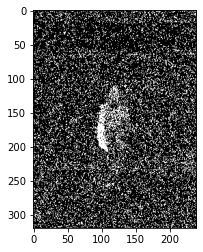

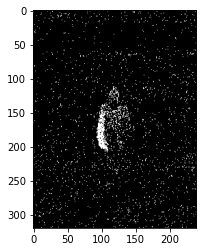

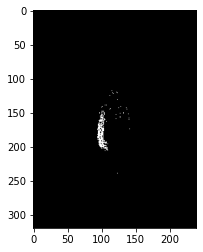

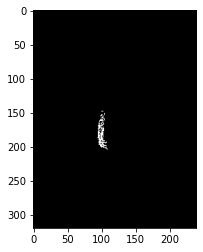

In [279]:
differenceImagesList_3 = differenceImages(3)            #Call function to store differnce images for T=3 in list 'differenceImageList'
differenceImagesList_5 = differenceImages(5)
differenceImagesList_10 = differenceImages(10)
differenceImagesList_15 = differenceImages(15)

plt.subplot(1,1,1)
plt.imshow(differenceImagesList_3[1], cmap='gray')
plt.show()

plt.subplot(1,1,1)
plt.imshow(differenceImagesList_5[1], cmap='gray')
plt.show()

plt.subplot(1,1,1)
plt.imshow(differenceImagesList_10[1], cmap='gray')
plt.show()

plt.subplot(1,1,1)
plt.imshow(differenceImagesList_15[1], cmap='gray')
plt.show()



From above results, I chose results from T = 10 for further process

### Perform median filtering on difference images with T = 10

In [289]:
differenceImagesList_10Filtered = []                              #Create empty list to store filtered difference images

for i in range(len(differenceImagesList_10)):
    median = median_filter(differenceImagesList_10[i],6)
    differenceImagesList_10Filtered.append(median)
    

### Display all the 21 filtered difference images using T = 10

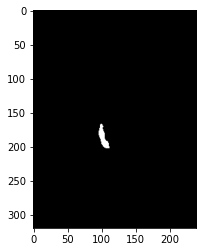

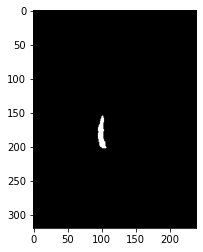

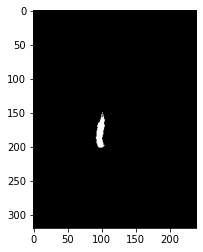

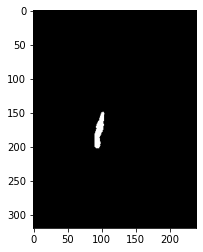

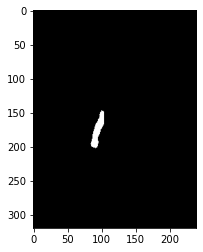

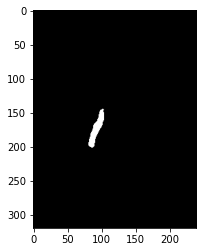

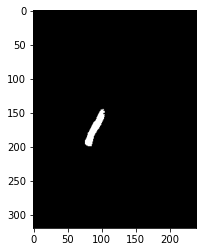

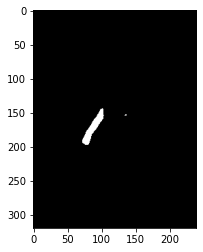

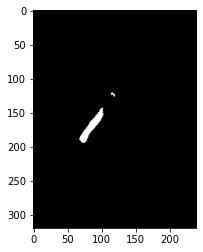

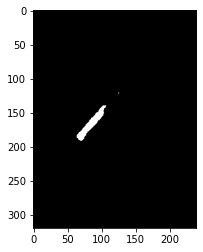

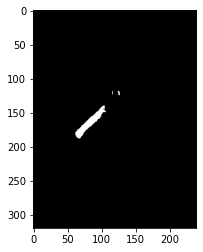

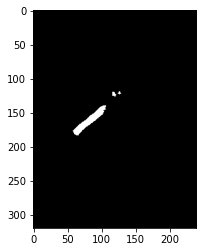

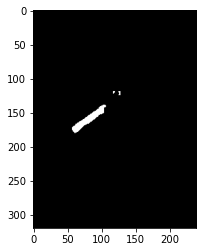

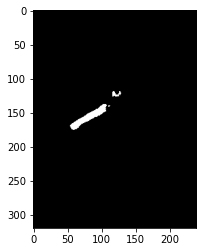

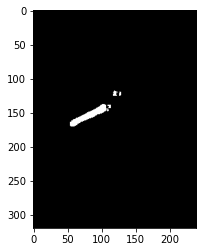

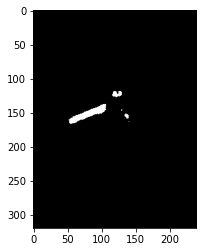

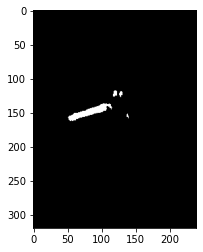

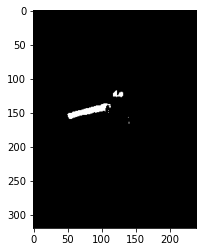

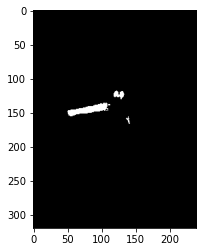

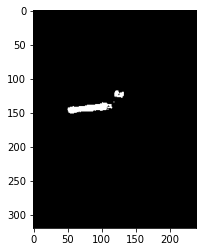

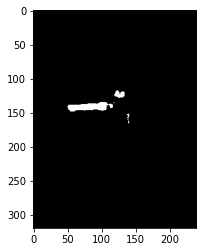

In [294]:
for i in range(len(differenceImagesList_10Filtered)):
    plt.subplot(1,1,1)
    plt.imshow(differenceImagesList_10Filtered[i], cmap='gray')
    plt.show()

#print(differenceImagesList_10Filtered[0].shape)

### Discussion

Performed motion motion detection using image differencing using different threshholds (T=3,5,10,15). T=3&5 were discarded because of too much noise and T=15 was discarded because some information about actual motion was getting lost. T=10 was taken as the ideal threshhold value as it provided maximum information about the motion. Median filtering was performed on all 21 difference images to remove any 'salt and pepper' noise

## Question 2

### Create function to compute MHI from filtered difference images

In [485]:
def generateMHI(imageList,delta):
    a,b = imageList[0].shape
    mhi = np.zeros_like(imageList[0])
    mhiPrevious = np.zeros_like(imageList[0])
    tau = 1
    
    for image in imageList:
        for i in range(a):
            for j in range(b):
                if(image[i][j] != 0):
                    mhi[i][j] = tau
                elif(mhiPrevious[i][j] < tau - delta):
                    mhi[i][j] = 0
        mhiPrevious = mhi
        tau += 1
    return mhi

### Compute and plot MHI for delta = 5

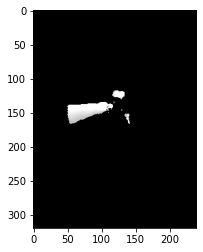

In [491]:
mhiDelta5 = generateMHI(differenceImagesList_10Filtered,5)
plt.subplot(1,1,1)
plt.imshow(mhiDelta5, cmap='gray')
plt.show()

### Compute and plot MHI for delta = 10

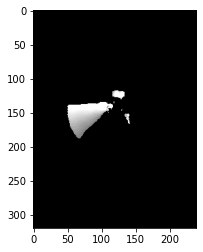

In [492]:
mhiDelta10 = generateMHI(differenceImagesList_10Filtered,10)
plt.subplot(1,1,1)
plt.imshow(mhiDelta10, cmap='gray')
plt.show()

### Compute and plot MHI for delta = 20

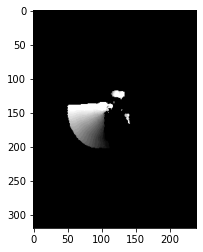

In [493]:
mhiDelta20 = generateMHI(differenceImagesList_10Filtered,20)
plt.subplot(1,1,1)
plt.imshow(mhiDelta20, cmap='gray')
plt.show()

We see that maximum information can be perceived from MHI when delta = 20

### Create function to compute MEI from MHI

In [505]:
def generateMEI(generatedMHI):
    mei = np.zeros_like(generatedMHI)
    a,b = generatedMHI.shape
    
    for i in range(a):
        for j in range(b):
            mei[i][j] = np.where(generatedMHI[i][j] != 0, 21,0)
    return mei

### Compute and plot MEI using MHI for delta = 20

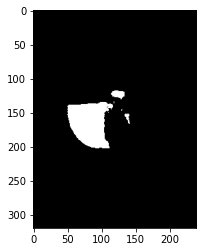

In [574]:
meiDelta20 = generateMEI(mhiDelta20)
plt.subplot(1,1,1)
plt.imshow(meiDelta20, cmap='gray')
plt.show()
#print(meiDelta20.max())

### Create function to Normalize

In [507]:
def generateNormalized(inputImage):
    a,b = inputImage.shape
    normalizedArray = np.zeros((a,b))
    
    for i in range(a):
        for j in range(b):
            normalizedArray[i][j] = max(0, (inputImage[i][j] - 1.0) / 21.0)
    return normalizedArray

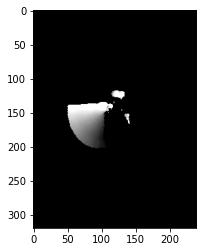

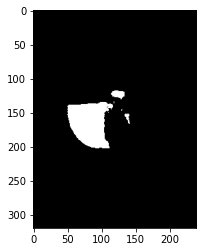

In [509]:
mhiNormalized = generateNormalized(mhiDelta20)
meiNormalized = generateNormalized(meiDelta20)

plt.subplot(1,1,1)
plt.imshow(mhiNormalized, cmap='gray')
plt.show()

plt.subplot(1,1,1)
plt.imshow(meiNormalized, cmap='gray')
plt.show()

### Create function to compute 7 similitude moments

In [510]:
def similitudeMoments(inputImage):
    
    a,b = inputImage.shape
    x=0
    y=0
    m10 = 0
    m01 = 0
    m00 = 0
    centroidX = 0
    centroidY = 0
    for x in range(a):
        for y in range(b):
                m10 += (x**1)*(y**0)*inputImage[x,y]
                m01 += (x**0)*(y**1)*inputImage[x,y]
                m00 += (x**0)*(y**0)*inputImage[x,y]
    
    centroidX = (m10) / (m00)
    centroidY = (m01) / (m00)
    
    # For similitudeMoment1, p=0, q=2
    # For similitudeMoment2, p=0, q=3
    # For similitudeMoment3, p=1, q=1
    # For similitudeMoment4, p=1, q=2
    # For similitudeMoment5, p=2, q=0
    # For similitudeMoment6, p=2, q=1
    # For similitudeMoment7, p=3, q=0
    
    N = np.array([[0,2],[0,3],[1,1],[1,2],[2,0],[2,1],[3,0]])
    numerator1 = 0
    denominator1 = 0
    numerator2 = 0
    denominator2 = 0
    numerator3 = 0
    denominator3 = 0
    numerator4 = 0
    denominator4 = 0
    numerator5 = 0
    denominator5 = 0
    numerator6 = 0
    denominator6 = 0
    numerator7 = 0
    denominator7 = 0
    #print(N)
    for x in range(a):
        for y in range(b):
                numerator1 += ((x - centroidX)**N[0,0]) * ((y - centroidY)**N[0,1]) * inputImage[x,y]
                denominator1 = (m00)**(((N[0,0] + N[0,1]) / 2) + 1)
            
                numerator2 += ((x - centroidX)**N[1,0]) * ((y - centroidY)**N[1,1]) * inputImage[x,y]
                denominator2 = (m00)**(((N[1,0] + N[1,1] / 2)) + 1)
                
                numerator3 += ((x - centroidX)**N[2,0]) * ((y - centroidY)**N[2,1]) * inputImage[x,y]
                denominator3 = (m00)**(((N[2,0] + N[2,1]) / 2) + 1)
                
                numerator4 += ((x - centroidX)**N[3,0]) * ((y - centroidY)**N[3,1]) * inputImage[x,y]
                denominator4 = (m00)**(((N[3,0] + N[3,1]) / 2) + 1)
                
                numerator5 += ((x - centroidX)**N[4,0]) * ((y - centroidY)**N[4,1]) * inputImage[x,y]
                denominator5 = (m00)**(((N[4,0] + N[4,1]) / 2) + 1)
                
                numerator6 += ((x - centroidX)**N[5,0]) * ((y - centroidY)**N[5,1]) * inputImage[x,y]
                denominator6 = (m00)**(((N[5,0] + N[5,1]) / 2) + 1)
                
                numerator7 += ((x - centroidX)**N[6,0]) * ((y - centroidY)**N[6,1]) * inputImage[x,y]
                denominator7 = (m00)**(((N[6,0] + N[6,1]) / 2) + 1)
    
    
    similitudeMoment1 = numerator1 / denominator1
    similitudeMoment2 = numerator2 / denominator2
    similitudeMoment3 = numerator3 / denominator3
    similitudeMoment4 = numerator4 / denominator4
    similitudeMoment5 = numerator5 / denominator5
    similitudeMoment6 = numerator6 / denominator6
    similitudeMoment7 = numerator7 / denominator7
    
    Nvals = [similitudeMoment1,similitudeMoment2,similitudeMoment3,similitudeMoment4,similitudeMoment5,similitudeMoment6,similitudeMoment7]            
    return Nvals

### Compute and display 7 similtude values for MHI and MEI

In [512]:
mhiMoments = similitudeMoments(mhiNormalized)
meiMoments = similitudeMoments(meiNormalized)

print(mhiMoments)
print(meiMoments)

[0.22776379176224912, 0.07369891788918811, -0.0688573593127679, -0.046076683780577596, 0.15403848735945783, 0.028993193381589843, 0.02188461063917473]
[0.11235248865115488, 0.017121394225521006, -0.016949438274012858, -0.022104941981260992, 0.12560902493721837, 0.02165446032400432, -0.00044103248138182796]


### Discussion

MHI displays information about the motion that has occured more recently when delta is small (delta=5) and information about motion that has occured in past when delta is large (delta=10 or 20). MEI was calculated using basic threshholding technique and later both MHI and MEI were normalized using the given formula. Also, none of the seven similitude moments for MHI or MEI were zero

## Question 3

### Create and display 21 x 21 box at row = 40, col = 6 and another box shifted 1-pixel right and down

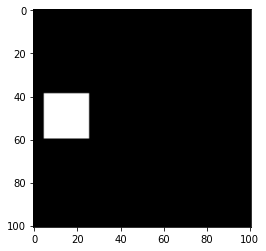

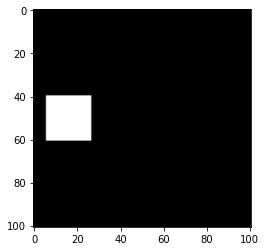

In [517]:
boxImage1 = np.zeros((101,101))
boxImage1[39:60,5:26] = 255
plt.subplot(1,1,1)
plt.imshow(boxImage1, cmap='gray')
plt.show()

boxImage2 = np.zeros((101,101))
boxImage2[40:61,6:27] = 255
plt.subplot(1,1,1)
plt.imshow(boxImage2, cmap='gray')
plt.show()

### Create a function to perform Sobel operation

In [525]:
def performSobel(inputImage):
    maskArrayX = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
    maskArrayY = np.array(([-1,-2,-1],[0,0,0],[1,2,1]))
    outputImageX = np.zeros_like(inputImage)
    outputImageY = np.zeros_like(inputImage)
    
    a,b = inputImage.shape
    
    for i in range(a):
        for j in range(b):
            if((i > 0 and i < a-1) and (j > 0 and j < b-1)):
                outputImageX[i][j] = (inputImage[i-1][j-1]*maskArrayX[0,0] + inputImage[i-1][j]*maskArrayX[0,1] + inputImage[i-1][j+1]*maskArrayX[0,2] + inputImage[i][j-1]*maskArrayX[1,0] + inputImage[i][j]*maskArrayX[1,1] + inputImage[i][j+1]*maskArrayX[1,2] + inputImage[i+1][j-1]*maskArrayX[2,0] + inputImage[i+1][j]*maskArrayX[2,1] + inputImage[i+1][j+1]*maskArrayX[2,2]) / 8
    
    for i in range(a):
        for j in range(b):
            if((i > 0 and i < a-1) and (j > 0 and j < b-1)):
                outputImageY[i][j] = (inputImage[i-1][j-1]*maskArrayY[0,0] + inputImage[i-1][j]*maskArrayY[0,1] + inputImage[i-1][j+1]*maskArrayY[0,2] + inputImage[i][j-1]*maskArrayY[1,0] + inputImage[i][j]*maskArrayY[1,1] + inputImage[i][j+1]*maskArrayY[1,2] + inputImage[i+1][j-1]*maskArrayY[2,0] + inputImage[i+1][j]*maskArrayY[2,1] + inputImage[i+1][j+1]*maskArrayY[2,2]) / 8
    
    return outputImageX, outputImageY
   

### Perform sobel operation on boxImage1 and display results

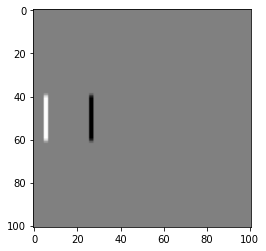

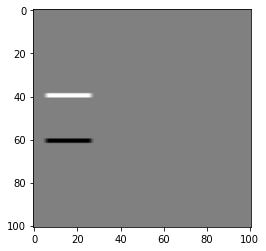

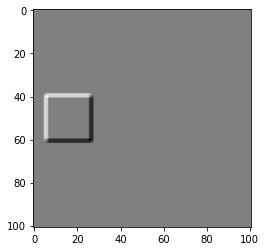

In [557]:
#Perform Sobel-X operation and store results in Fx. Perform Sobel-Y operation and store results in Fy

Fx,Fy = performSobel(boxImage2)
plt.subplot(1,1,1)
plt.imshow(Fx, cmap='gray')
plt.show()
plt.subplot(1,1,1)
plt.imshow(Fy, cmap='gray')
plt.show()
plt.subplot(1,1,1)
plt.imshow(Fx + Fy, cmap='gray')
plt.show()

### Compute Ft for boxImage1 and boxImage2

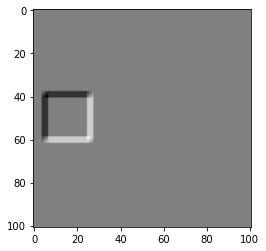

In [554]:
#First we need to perform averaging on the input images

boxImage1smooth = cv.blur(boxImage1,(3,3))
boxImage2smooth = cv.blur(boxImage2,(3,3))

#Create an empty array Ft which will store the difference values between two input smooth images

Ft = np.zeros_like(boxImage1smooth)

Ft = boxImage2smooth - boxImage1smooth
plt.subplot(1,1,1)
plt.imshow(Ft, cmap='gray')
plt.show()


### Normal Optic Flow calculation

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_748/283812973.py:8: RuntimeWarning: invalid value encountered in double_scalars
  Fxn[i][j] = Fx[i][j] / denominator
/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_748/283812973.py:9: RuntimeWarning: invalid value encountered in double_scalars
  Fyn[i][j] = Fy[i][j] / denominator


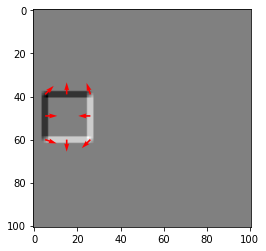

In [584]:
Fxn = np.zeros_like(Fx)
Fyn = np.zeros_like(Fy)
a,b = Fx.shape

for i in range(a):
    for j in range(b):
        denominator = math.sqrt(Fx[i][j]**2 + Fy[i][j]**2)
        Fxn[i][j] = Fx[i][j] / denominator
        Fyn[i][j] = Fy[i][j] / denominator

#Plot Quiver for all four edges and 4 corners

plt.imshow(Ft,cmap='gray')
plt.quiver(5,49,Fxn[49,5],Fyn[49,5],linewidth = 0.3, color='red')
plt.quiver(26,49,Fxn[49,26],Fyn[49,26],linewidth = 0.3, color='red')
plt.quiver(15,39,Fxn[39,15],Fyn[39,15],linewidth = 0.3, color='red')
plt.quiver(15,60,Fxn[60,15],Fyn[60,15],linewidth = 0.3, color='red')

plt.quiver(5,39,Fxn[39,5],Fyn[39,5],linewidth = 0.3, color='red')
plt.quiver(26,39,Fxn[39,26],Fyn[39,26],linewidth = 0.3, color='red')
plt.quiver(5,60,Fxn[60,5],Fyn[60,5],linewidth = 0.3, color='red')
plt.quiver(26,60,Fxn[60,26],Fyn[60,26],linewidth = 0.3, color='red')

### Displaying normal flow for all pixels in the image

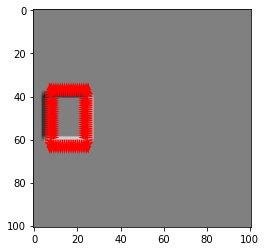

In [570]:
plt.imshow(Ft,cmap='gray')
for i in range(a):
    for j in range(b):
        plt.quiver(j,i,Fxn[i,j],Fyn[i,j],linewidth = 0.1, color='red')

### Discussion

Results after performing sobel operation X (Fx), sobel operation Y (Fy), and difference image (Ft) after performing averaging were dispalyed. Normal flow calculation show that vectors generated on left and bottom edge are correct. And only the bottom left corner vector point towards the correct direction. Remaining two edges (top and right), and remaining 3 corners, all point in the direction opposite to the actual motion.